<a href="https://colab.research.google.com/github/neilghosh2000/CS6910_Assignment1/blob/main/CS6910_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install wandb

     |████████████████████████████████| 2.0MB 6.3MB/s 
     |████████████████████████████████| 133kB 32.9MB/s 
     |████████████████████████████████| 163kB 20.2MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=5596545d124bf93bf4cb4058bbcd368a16f83f58060f898f01c4da9c760c678b
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=a3a9eb502d53ed3d79a4e7c06f849d13ce2c14dffc57efb6244fbf6eddf3604b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [1]:
# the best set of hyperparameters that we get from the sweep
default_parameters = dict(
    n_layers= 4,
    hidden_layer_size= 128,
    learn_rate= 1e-3,
    batch_size = 16,
    epochs=10,
    alpha = 0,
    optimizer = "nadam",
    activation = "relu",
    weight_init = "random"
    )
config = default_parameters

In [6]:
import wandb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [7]:
run = wandb.init(config= default_parameters,project="cs6910_assignment_1", entity="neilghosh")
config = wandb.config

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
#import the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


4423680/4422102 [==============================] - 0s 0us/step


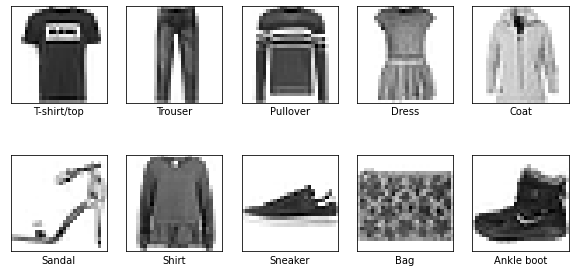

In [9]:
# plot one sample image from each class arnesh
sample_images = []
plt.figure(figsize=(10,5))
for i in range(len(class_names)):
    sample_images.append(train_labels.tolist().index(i))
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[sample_images[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[sample_images[i]]])

wandb.log({"sample_images": plt})

In [10]:
def one_hot_vector(x):
  y = np.zeros((x.size, x.max()+1))
  y[np.arange(x.size),x] = 1
  return y

In [12]:
input_size = train_images.shape[1]*train_images.shape[2]
output_size = len(class_names)

train_x = train_images.reshape([train_images.shape[0], input_size, 1])/255
test_x = test_images.reshape([test_images.shape[0], input_size, 1])/255

# shuffle the training data
indices = np.arange(train_x.shape[0])
np.random.shuffle(indices)

train_y = one_hot_vector(train_labels)
test_y = one_hot_vector(test_labels)

train_x = train_x[indices]
train_y = train_y[indices]

train_y = np.dstack([train_y])
test_y = np.dstack([test_y])

val_x = train_x[int(len(train_x)*0.9):,:,:]
val_y = train_y[int(len(train_y)*0.9):,:,:]

train_x = train_x[:int(len(train_x)*0.9),:,:]
train_y = train_y[:int(len(train_y)*0.9),:,:]

In [14]:
nn_layers = [{"input_dim" : input_size, "output_dim" : config.hidden_layer_size, "activation" : config.activation}]
for i in range(config.n_layers-1):
  nn_layers.append({"input_dim" : config.hidden_layer_size, "output_dim" : config.hidden_layer_size, "activation" : config.activation})
nn_layers.append({"input_dim" : config.hidden_layer_size, "output_dim" : output_size, "activation" : "softmax"})


In [16]:
def init_layers(nn_layers, weight_init, seed = 45):
    np.random.seed(seed)
    weights = {}

    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        if weight_init == "random":
          weights['w' + str(layer_no)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
          weights['b' + str(layer_no)] = np.random.randn(layer_output_size, 1) * 0.1
        elif weight_init == "xavier":
          limit = np.sqrt(6/(layer_input_size + layer_output_size))
          weights['w' + str(layer_no)] = np.random.uniform(-limit, limit, size=(layer_output_size, layer_input_size))
          weights['b' + str(layer_no)] = np.random.uniform(-limit, limit, size=(layer_output_size, 1))
        else:
          return "Error - Weight Initialization"

    return weights

In [11]:
def activation_func(z, activation="sigmoid"):
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif activation == "softmax":
        z1 = np.exp(z)
        z2 = z1.sum(axis=1)
        z2 = np.dstack([z2])
        return z1/z2
    elif activation == "tanh":
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    elif activation == "relu":
        return np.maximum(0, z)

    else:
        return "Error"

def activation_derivative(z, activation="sigmoid"):
    if activation == "sigmoid":
      sig = 1 / (1 + np.exp(-z))
      return sig*(1-sig)
    elif activation == "tanh":
      tanh = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
      return 1 - tanh**2
    elif activation == "relu":
      relu = np.maximum(0, z)
      relu[relu > 0] = 1
      return relu
    else:
      return "Error"


In [17]:
def forward_prop(train_x, weights, nn_layers):
    layer_output = {}
    h_curr = train_x

    layer_output["h0"] = train_x
    layer_output["a0"] = train_x

    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        h_prev = h_curr

        activation = layer["activation"]
        w_curr = weights["w" + str(layer_no)]
        b_curr = weights["b" + str(layer_no)]

        a_curr = np.matmul(w_curr, h_prev) + b_curr
        h_curr = activation_func(a_curr, activation)

        layer_output["a" + str(layer_no)] = a_curr
        layer_output["h" + str(layer_no)] = h_curr

    return h_curr, layer_output

In [18]:
# cross entropy loss + regularization

def loss_func(y_hat, y, alpha, weights, nn_layers):
    cross_entropy = -np.multiply(y, np.log(y_hat)).sum() / len(y_hat)

    l2_reg = 0
    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        l2_reg += np.sum(weights["w" + str(layer_no)] ** 2)

    l2_reg = (alpha / 2) * l2_reg / len(y_hat)

    return cross_entropy + l2_reg

# accuracy
def accuracy_func(y_hat, train_y):
    correct_pred = np.argmax(y_hat, axis = 1) == np.argmax(train_y, axis = 1)
    return sum(bool(x) for x in correct_pred)/len(y_hat)

In [19]:
def back_prop(y_hat, y, layer_output, weights, nn_layers, alpha):
    gradients = {}

    da_prev = -(y - y_hat)

    m = len(y_hat)

    for i, layer in reversed(list(enumerate(nn_layers))):
        layer_index = i + 1

        da_curr = da_prev

        a_prev = layer_output["a" + str(i)]
        h_prev = layer_output["h" + str(i)]
        dh_prev = np.zeros(h_prev.shape)

        a_curr = layer_output["a" + str(layer_index)]
        w_curr = weights["w" + str(layer_index)]
        b_curr = weights["b" + str(layer_index)]
        dw_curr = np.zeros(w_curr.shape)
        db_curr = np.zeros(b_curr.shape)

        for j in range(m):
            dw_curr += np.dot(da_curr[j], h_prev[j].T)
            db_curr += da_curr[j]
            dh_prev[j] = np.dot(w_curr.T, da_curr[j])

        dw_curr += alpha * w_curr

        dw_curr /= m
        db_curr /= m

        if i > 0:
            activation = nn_layers[i - 1]["activation"]
            da_prev = np.multiply(dh_prev, activation_derivative(a_prev, activation))

        gradients["dw" + str(layer_index)] = dw_curr
        gradients["db" + str(layer_index)] = db_curr

    return gradients


In [20]:
def gradient_descent(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          weights["w" + str(k+1)] -= eta * gradients["dw" + str(k+1)]        
          weights["b" + str(k+1)] -= eta * gradients["db" + str(k+1)]

        print(j)

    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " epochs completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list


In [21]:
def calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha):

    y_hat, layer_output = forward_prop(train_x, weights, nn_layers)
    training_loss = (loss_func(y_hat, train_y, alpha, weights, nn_layers))
    training_accuracy = (accuracy_func(y_hat, train_y))

    y_hat, layer_output = forward_prop(test_x, weights, nn_layers)
    val_loss = (loss_func(y_hat, test_y, alpha, weights, nn_layers))
    val_accuracy = (accuracy_func(y_hat, test_y))

    wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy})

    return training_loss, training_accuracy, val_loss, val_accuracy


In [22]:
def momentum_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  prev_weights = {}

  gamma = 0.9

  for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          prev_weights["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = gamma * prev_weights["w" + str(k+1)] + eta * gradients["dw" + str(k+1)]     
          prev_weights["b" + str(k+1)] = gamma * prev_weights["b" + str(k+1)] + eta * gradients["db" + str(k+1)]   

          weights["w" + str(k+1)] -= prev_weights["w" + str(k+1)]        
          weights["b" + str(k+1)] -= prev_weights["b" + str(k+1)]


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [23]:
def nesterov_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  prev_weights = {}
  look_ahead_w = {}
  
  gamma = 0.9

  for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          prev_weights["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        for k, layer in enumerate(nn_layers):
          look_ahead_w["w" + str(k+1)] = weights["w" + str(k+1)] - gamma * prev_weights["w" + str(k+1)]
          look_ahead_w["b" + str(k+1)] = weights["b" + str(k+1)] - gamma * prev_weights["b" + str(k+1)]

        y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = gamma * prev_weights["w" + str(k+1)] + eta * gradients["dw" + str(k+1)]     
          prev_weights["b" + str(k+1)] = gamma * prev_weights["b" + str(k+1)] + eta * gradients["db" + str(k+1)]   

          weights["w" + str(k+1)] -= prev_weights["w" + str(k+1)]        
          weights["b" + str(k+1)] -= prev_weights["b" + str(k+1)]


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [24]:
def rmsprop(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}

  beta = 0.9
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta * v["w" + str(k+1)] + (1-beta) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta * v["b" + str(k+1)] + (1-beta) * gradients["db" + str(k+1)]**2   

          weights["w" + str(k+1)] -= eta * np.divide(gradients["dw" + str(k+1)], np.sqrt(v["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(gradients["db" + str(k+1)], np.sqrt(v["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [25]:
def adam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}
  v_hat = {}
  m = {}
  m_hat = {}

  beta1 = 0.9
  beta2 = 0.999
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)
          m["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          m["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  t = 0

  for i in range(epochs):
    for j in range(n_batches):

        t += 1

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta2 * v["w" + str(k+1)] + (1-beta2) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta2 * v["b" + str(k+1)] + (1-beta2) * gradients["db" + str(k+1)]**2 

          m["w" + str(k+1)] = beta1 * m["w" + str(k+1)] + (1-beta1) * gradients["dw" + str(k+1)]    
          m["b" + str(k+1)] = beta1 * m["b" + str(k+1)] + (1-beta1) * gradients["db" + str(k+1)] 

          v_hat["w" + str(k+1)] = np.divide(v["w" + str(k+1)], (1-beta2**t))
          v_hat["b" + str(k+1)] = np.divide(v["b" + str(k+1)], (1-beta2**t))

          m_hat["w" + str(k+1)] = np.divide(m["w" + str(k+1)], (1-beta1**t))
          m_hat["b" + str(k+1)] = np.divide(m["b" + str(k+1)], (1-beta1**t))

          weights["w" + str(k+1)] -= eta * np.divide(m_hat["w" + str(k+1)], np.sqrt(v_hat["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(m_hat["b" + str(k+1)], np.sqrt(v_hat["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [26]:
def nadam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}
  v_hat = {}
  m = {}
  m_hat = {}

  look_ahead_w = {}
  look_ahead_m_hat = {}
  look_ahead_v_hat = {}

  beta1 = 0.9
  beta2 = 0.999
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)
          m["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          m["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  t = 0

  for i in range(epochs):
    for j in range(n_batches):

        t += 1

        for k, layer in enumerate(nn_layers):

          look_ahead_v_hat["w" + str(k+1)] = np.divide(beta2 * v["w" + str(k+1)], (1-beta2**t))
          look_ahead_v_hat["b" + str(k+1)] = np.divide(beta2 * v["b" + str(k+1)], (1-beta2**t))

          look_ahead_m_hat["w" + str(k+1)] = np.divide(beta1 * m["w" + str(k+1)], (1-beta1**t))
          look_ahead_m_hat["b" + str(k+1)] = np.divide(beta1 * m["b" + str(k+1)], (1-beta1**t))

          look_ahead_w["w" + str(k+1)] = weights["w" + str(k+1)] - eta * np.divide(look_ahead_m_hat["w" + str(k+1)], np.sqrt(look_ahead_v_hat["w" + str(k+1)] + epsilon))
          look_ahead_w["b" + str(k+1)] = weights["b" + str(k+1)] - eta * np.divide(look_ahead_m_hat["b" + str(k+1)], np.sqrt(look_ahead_v_hat["b" + str(k+1)] + epsilon))

        y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers, alpha)

        for k, layer in enumerate(nn_layers):
          
          v["w" + str(k+1)] = beta2 * v["w" + str(k+1)] + (1-beta2) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta2 * v["b" + str(k+1)] + (1-beta2) * gradients["db" + str(k+1)]**2 

          m["w" + str(k+1)] = beta1 * m["w" + str(k+1)] + (1-beta1) * gradients["dw" + str(k+1)]    
          m["b" + str(k+1)] = beta1 * m["b" + str(k+1)] + (1-beta1) * gradients["db" + str(k+1)] 

          v_hat["w" + str(k+1)] = np.divide(v["w" + str(k+1)], (1-beta2**t))
          v_hat["b" + str(k+1)] = np.divide(v["b" + str(k+1)], (1-beta2**t))

          m_hat["w" + str(k+1)] = np.divide(m["w" + str(k+1)], (1-beta1**t))
          m_hat["b" + str(k+1)] = np.divide(m["b" + str(k+1)], (1-beta1**t))

          weights["w" + str(k+1)] -= eta * np.divide(m_hat["w" + str(k+1)], np.sqrt(v_hat["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(m_hat["b" + str(k+1)], np.sqrt(v_hat["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [27]:
def train(train_x, train_y, test_x, test_y, nn_layers, epochs, eta, batch_size, optimizer, weight_init, alpha):
    
    weights = init_layers(nn_layers, weight_init)
    
    n_batches = len(train_x)//batch_size

    if optimizer == "gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = gradient_descent(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    elif optimizer == "momentum_gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = momentum_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    elif optimizer == "nesterov_accelerated_gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = nesterov_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    elif optimizer == "rmsprop":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = rmsprop(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    elif optimizer == "adam":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = adam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    elif optimizer == "nadam":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = nadam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha)

    else:
      return "Error - Wrong Optimizer"
        
    return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [28]:
eta = config.learn_rate
epochs = config.epochs
batch_size = config.batch_size
optimizer = config.optimizer
weight_init = config.weight_init
alpha = config.alpha

# batch_size = 1 for stochastic and batch_size = len(train_x) for batch updates


weights, train_loss, train_accuracy, val_loss, val_accuracy = train(train_x, train_y, val_x, val_y, nn_layers, epochs, eta, batch_size, optimizer, weight_init, alpha)


1/10 completed
2/10 completed
3/10 completed
4/10 completed
5/10 completed
6/10 completed
7/10 completed
8/10 completed
9/10 completed
10/10 completed


In [ ]:
# save the optimized weights
with open('weights.pickle', 'wb') as handle:
    pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
train_loss

[0.3590270576872821,
 0.32380800069292065,
 0.2981786114836236,
 0.28590518226997974,
 0.29064502335706477,
 0.27446551037033073,
 0.27314264897253926,
 0.24433381854026845,
 0.2504163716137341,
 0.23398488781872365]

In [30]:
train_accuracy

[0.8722037037037037,
 0.8825185185185185,
 0.8892407407407408,
 0.8957037037037037,
 0.8947407407407407,
 0.8978148148148148,
 0.8979259259259259,
 0.9095740740740741,
 0.9071851851851852,
 0.9131111111111111]

In [31]:
config

{'n_layers': 4, 'hidden_layer_size': 128, 'learn_rate': 0.001, 'batch_size': 16, 'epochs': 10, 'alpha': 0, 'optimizer': 'nadam', 'activation': 'relu', 'weight_init': 'random'}

In [33]:
val_accuracy

[0.867,
 0.8745,
 0.8786666666666667,
 0.8853333333333333,
 0.8766666666666667,
 0.8751666666666666,
 0.8781666666666667,
 0.8873333333333333,
 0.8853333333333333,
 0.8895]

In [34]:
val_loss

[0.3820773694599643,
 0.35793171661765594,
 0.3441491776290571,
 0.3355184181295215,
 0.35577333535480155,
 0.341224194275083,
 0.3486184030064242,
 0.3270737413914123,
 0.3494800805594172,
 0.33733191357333325]